In [122]:
from dotenv import load_dotenv
from langchain_anthropic import ChatAnthropic
import datetime
from datetime import timedelta

load_dotenv(dotenv_path="../.env", override=True)
model = ChatAnthropic(model='claude-3-sonnet')


In [123]:
# !pip install -U "langchain[anthropic]"

In [124]:
# !pip install langchain-community


In [125]:
import os
from langchain.chat_models import init_chat_model

os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")

In [126]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any
import pandas as pd

In [127]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("../database/united_ops.db")

# Load full crew schedule including legality-related fields
mock_crew_schedule = pd.read_sql_query("""
    SELECT
        crew_id,
        name,
        assigned_flight,
        base,
        duty_start,
        duty_end,
        rest_hours_prior,
        last_flight_end,
        fatigue_score,
        role
    FROM crew
    WHERE duty_start IS NOT NULL AND duty_end IS NOT NULL
""", conn)

# Convert time fields to datetime
mock_crew_schedule[["duty_start", "duty_end", "last_flight_end"]] = mock_crew_schedule[
    ["duty_start", "duty_end", "last_flight_end"]
].apply(pd.to_datetime)

# Optionally load passengers for rebooking agent later
mock_passenger_itinerary = pd.read_sql_query("""
    SELECT passenger_id, flight_number, loyalty_tier
    FROM passengers
""", conn)

conn.close()

print(mock_crew_schedule.head())


     crew_id    name assigned_flight base          duty_start  \
0  DL7016_C0  Crew_0          DL7016  ORD 2025-06-25 03:56:00   
1  DL7016_C1  Crew_1          DL7016  ORD 2025-06-25 03:56:00   
2  DL7016_C2  Crew_2          DL7016  ORD 2025-06-25 03:56:00   
3  DL7016_C3  Crew_3          DL7016  ORD 2025-06-25 03:56:00   
4  DL7016_C4  Crew_4          DL7016  ORD 2025-06-25 03:56:00   

             duty_end  rest_hours_prior     last_flight_end  fatigue_score  \
0 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   
1 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   
2 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   
3 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   
4 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   

        role  
0      Pilot  
1  Attendant  
2  Attendant  
3  Attendant  
4  Attendant  


In [128]:
import sqlite3
import json
from datetime import datetime
from langchain.tools import tool

DB_PATH = "../database/united_ops.db"

@tool
def log_message_tool(agent_name: str, message: str, run_id: str = "default", context: dict = None) -> str:
    """
    Logs a message from an agent to the shared agent_logs table in SQLite.

    Args:
        agent_name (str): The name of the agent logging the message.
        message (str): The log message.
        run_id (str): A shared identifier for this run of the planner.
        context (dict, optional): Any structured metadata (flight_id, crew, etc.).

    Returns:
        str: Confirmation that the message was logged.
    """
    try:
        conn = sqlite3.connect(DB_PATH)
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS agent_logs (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp TEXT DEFAULT (DATETIME('now')),
                run_id TEXT,
                agent_name TEXT,
                message TEXT,
                context TEXT
            )
        """)
        cursor.execute("""
            INSERT INTO agent_logs (run_id, agent_name, message, context)
            VALUES (?, ?, ?, ?)
        """, (
            run_id,
            agent_name,
            message,
            json.dumps(context or {})
        ))
        conn.commit()
        return f"✅ Logged message for {agent_name}"
    except Exception as e:
        return f"❌ Failed to log message: {str(e)}"
    finally:
        conn.close()


### Shared agent state definition

In [129]:
from typing import Annotated, TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
import pandas as pd
from operator import add

class SystemState(TypedDict):
    proposals: Annotated[List[Dict[str, Any]], add]
    crew_schedule: pd.DataFrame
    passenger_itinerary: pd.DataFrame
    legality_flags: Annotated[List[str], add]
    crew_substitutions: Dict[str, List[str]]
    current_flight_crews: Dict[str, List[str]]
    messages: Annotated[List[str], add]
    iteration_count: int
    plan_summary: str
    final_plan: Dict[str, Any]
    rebooking_proposals: Annotated[List[Dict[str, Any]], add]


### Crew Ops Agent

In [130]:
from typing import List, Dict, Any
import pandas as pd
import sqlite3
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_anthropic import ChatAnthropic
from langchain.prompts import ChatPromptTemplate

# Constants
MAX_DUTY_HOURS = 10
MIN_REST_HOURS = 10
MAX_FATIGUE_SCORE = 1.0

@tool
def check_legality_tool(crew_schedule: List[Dict[str, Any]]) -> List[str]:
    """
    FAA legality check.
    Expects a flat list of crew members with keys:
    - assigned_flight
    - duty_start, duty_end
    - rest_hours_prior
    - fatigue_score
    If input is nested, it will be flattened.
    """
    # Handle nested input
    if all("crew" in item and "flight_id" in item for item in crew_schedule):
        flat_crew = []
        for flight in crew_schedule:
            for crew in flight["crew"]:
                crew["assigned_flight"] = flight["flight_id"]
                flat_crew.append(crew)
        crew_schedule = flat_crew

    df = pd.DataFrame(crew_schedule)

    required_cols = ["assigned_flight", "duty_start", "duty_end", "rest_hours_prior", "fatigue_score"]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required fields: {missing_cols}")

    violations = []
    for flight_id, group in df.groupby("assigned_flight"):
        for _, row in group.iterrows():
            duty_hours = (pd.to_datetime(row["duty_end"]) - pd.to_datetime(row["duty_start"])) / pd.Timedelta(hours=1)
            if duty_hours > MAX_DUTY_HOURS or row["rest_hours_prior"] < MIN_REST_HOURS or row["fatigue_score"] > MAX_FATIGUE_SCORE:
                violations.append(flight_id)
                break
    return list(set(violations))


@tool
def get_unassigned_crew_from_db(input: Dict[str, Any] = {}) -> List[Dict[str, Any]]:
    """
    Pulls unassigned crew directly from the SQLite database.
    Can be invoked with no parameters.

    Crew must have:
    - No current flight assignment (assigned_flight IS NULL)
    - Rest hours >= MIN_REST_HOURS
    - Fatigue score <= MAX_FATIGUE_SCORE
    """
    conn = sqlite3.connect("../database/united_ops.db")
    query = """
        SELECT crew_id, name, base, rest_hours_prior, fatigue_score, role
        FROM crew
        WHERE assigned_flight IS NULL
          AND rest_hours_prior >= ?
          AND fatigue_score <= ?
    """
    df = pd.read_sql_query(query, conn, params=(MIN_REST_HOURS, MAX_FATIGUE_SCORE))
    conn.close()
    return df.to_dict(orient="records")

@tool
def propose_substitutes_tool(violations: List[str], crew_schedule: List[Dict[str, Any]], unassigned_crew: List[Dict[str, Any]]) -> Dict[str, List[str]]:
    """
        Propose legal substitute crew members for flights that violate FAA rules.

        Input:
        - `violations` (list): A list of FAA violation entries. Each violation should reference a flight_id and the affected crew. Violations can be obtained from `check_legality_tool and have a structure of list of flight IDs that have violations.
        - `crew_schedule` (list): The current full crew schedule, with each entry containing fields like `crew_id`, `assigned_flight`, `role`, `base`, `fatigue_score`, and other relevant attributes.
        - `unassigned_crew` (list): A list of available crew members not currently assigned to a flight. Each must include:
            - `crew_id` (str)
            - `role` (str) — either "Pilot" or "Attendant"
            - `base` (str)
            - `fatigue_score` (float between 0 and 1)
            - optionally: `rest_hours_prior`, `last_flight_end`, etc.

        Usage:
        1. Always call `get_unassigned_crew_from_db` before using this tool.
        2. Ensure the unassigned crew have matching `role` and `base` to the affected crew in violations.
        3. The tool will match substitutes by lowest fatigue and highest availability.

        Output:
        - Returns a dictionary mapping `flight_id` to a list of proposed new crew assignments.
    """
    df = pd.DataFrame(crew_schedule)
    unassigned = pd.DataFrame(unassigned_crew)
    substitutions = {}
    for flight_id in violations:
        needed_roles = df[df["assigned_flight"] == flight_id]["role"].value_counts()
        crew_ids = []
        for role, count in needed_roles.items():
            eligible = unassigned[unassigned["role"] == role]
            selected = eligible.head(count)
            crew_ids.extend(selected["crew_id"].tolist())
            unassigned = unassigned[~unassigned["crew_id"].isin(selected["crew_id"])]
        substitutions[flight_id] = crew_ids
    return substitutions


@tool
def get_full_schedule_from_db(_: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Pulls the entire current crew schedule from the SQLite database,
    including assigned_flight, duty_start, fatigue_score, and other FAA-relevant fields.
    """
    conn = sqlite3.connect("../database/united_ops.db")
    df = pd.read_sql_query("""
        SELECT
            crew_id, name, assigned_flight, base, duty_start, duty_end,
            rest_hours_prior, last_flight_end, fatigue_score, role
        FROM crew
        WHERE duty_start IS NOT NULL AND duty_end IS NOT NULL
    """, conn)
    conn.close()
    df[["duty_start", "duty_end", "last_flight_end"]] = df[["duty_start", "duty_end", "last_flight_end"]].apply(pd.to_datetime)
    return df.to_dict(orient="records")


def crew_ops_anthropic_agent(state: Dict[str, Any]) -> Dict[str, Any]:
    print("🧑‍✈️ Claude CrewOpsAgent activated")
    state.setdefault("messages", []).append("Claude CrewOpsAgent analyzing FAA legality")

    llm = ChatAnthropic(model="claude-3-5-sonnet-latest", temperature=0.1)
    tools = [check_legality_tool, get_unassigned_crew_from_db, propose_substitutes_tool, log_message_tool]
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
        "You are a flight legality compliance agent.\n"
        "Step 1: Use `get_full_schedule_from_db` to load the crew schedule.\n"
        "Step 2: Use `check_legality_tool` to identify FAA violations.\n"
        "Step 3: Use `get_unassigned_crew_from_db` to get replacement candidates.\n"
        "Step 4: Use `propose_substitutes_tool` with the violations, crew schedule, and unassigned crew.\n"
        "If `unassigned_crew` is missing, re-run `get_unassigned_crew_from_db`.\n"
        "You must call `propose_substitutes_tool` with all required fields."),
        ("user", "{input}"),
        ("ai", "{agent_scratchpad}")
    ])

    agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    crew_schedule_df = state["crew_schedule"]

    try:
        result = agent_executor.invoke({
            "input": "Begin compliance review using FAA rules. Load crew schedule from the database and resolve any violations."
        })

        # If output is not a dict, extract it safely
        if isinstance(result, dict):
            substitutions = result
        else:
            substitutions = result.get("output", {})

    except Exception as e:
        print(f"⚠️ Initial attempt failed: {e}")
        state.setdefault("messages", []).append(f"CrewOpsAgent: Initial tool call failed, retrying manually")

        # Manual fallback
        try:
            # Retry: Run legality and substitutions directly
            crew_schedule = get_full_schedule_from_db({})
            violations = check_legality_tool(crew_schedule)
            unassigned_crew = get_unassigned_crew_from_db({})
            substitutions = propose_substitutes_tool(violations=violations, crew_schedule=crew_schedule, unassigned_crew=unassigned_crew)

        except Exception as e2:
            print(f"❌ Fallback also failed: {e2}")
            state.setdefault("messages", []).append("CrewOpsAgent failed to resolve substitutions")
            return state

    for flight_id, crew_list in substitutions.items():
        state.setdefault("crew_substitutions", {})[flight_id] = crew_list
        if crew_list:
            state.setdefault("current_flight_crews", {})[flight_id] = crew_list
            state.setdefault("messages", []).append(f"CrewOpsAgent: Substituted crew for flight {flight_id}")
            state.setdefault("proposals", []).append({
                "agent": "CrewOpsAgent",
                "flight": flight_id,
                "action": "Substitution",
                "reason": "FAA violation",
                "crew": crew_list
            })
        else:
            state.setdefault("messages", []).append(f"CrewOpsAgent: No substitute available for flight {flight_id}")

    state.setdefault("legality_flags", []).extend(list(substitutions.keys()))
    state["messages"].append("Claude CrewOpsAgent completed analysis")
    print("🧾 Messages before planner:", state.get("messages", []))
    return state



### PlannerAgent Node

In [131]:
import sqlite3
import os
import re
from langchain.tools import tool
from langchain_anthropic import ChatAnthropic
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.prompts import ChatPromptTemplate
from typing import Dict, Any, Union, List

DB_PATH = "../database/united_ops.db"

@tool
def read_messages_tool(run_id: str = "default") -> str:
    """
    Reads all agent messages for a given run_id from the agent_logs table in SQLite.

    Args:
        run_id (str): Unique identifier for this execution run (e.g., "UA-ops-2025-06-20")

    Returns:
        str: A formatted chronological log of all system messages for the run.
    """
    try:
        conn = sqlite3.connect(DB_PATH)
        cursor = conn.cursor()
        cursor.execute("""
            SELECT timestamp, agent_name, message
            FROM agent_logs
            WHERE run_id = ?
            ORDER BY timestamp ASC
        """, (run_id,))
        rows = cursor.fetchall()
        conn.close()

        if not rows:
            return f"No messages found in database for run_id: {run_id}"

        return "\n".join(f"{ts} | {agent}: {msg}" for ts, agent, msg in rows)

    except Exception as e:
        return f"❌ Error fetching messages from DB: {str(e)}"

def save_summary_to_markdown(summary_text: Union[str, List[str], dict], run_id: str = "default"):
    """
    Saves a clean executive summary (from Claude or string/list input) to a Markdown file.
    - Strips emoji
    - Normalizes section headers
    - Handles Claude-style dicts, strings, and lists

    Args:
        summary_text (Union[str, List[str], dict]): The summary content.
        run_id (str): Unique run ID used in the filename.
    """
    os.makedirs("outputs", exist_ok=True)
    filename = f"outputs/summary_{run_id}.md"

    # Extract raw text
    if isinstance(summary_text, dict) and "text" in summary_text:
        summary_text = summary_text["text"]
    elif isinstance(summary_text, list):
        summary_text = "\n\n".join(str(p).strip() for p in summary_text)
    summary_text = str(summary_text).strip()

    # Normalize and clean
    summary_text = summary_text.replace("EXECUTIVE SUMMARY", "").replace("Executive Summary", "")
    summary_text = summary_text.replace("----------", "").replace("--------", "")
    summary_text = summary_text.strip()

    # Strip emojis (basic ASCII-friendly filter)
    summary_text = re.sub(r"[^\x00-\x7F]+", "", summary_text)

    # Promote section headers like "Major Actions Taken:" to proper Markdown
    summary_text = re.sub(r"(?m)^([A-Z][A-Za-z ]+):\s*$", r"## \1", summary_text)

    # Final document
    formatted = f"""# Executive Summary – Run ID: {run_id}

{summary_text}
"""

    with open(filename, "w") as f:
        f.write(formatted)

    print(f"\nExecutive Markdown summary saved to: {filename}")


def planner_agent(state: Dict[str, Any], run_id: str = "default") -> Dict[str, Any]:
    """
    Planner agent that reads all logs from SQLite, generates an executive summary with Claude,
    updates the plan state, and saves a copy of the summary as a Markdown file.
    """
    print("🧠 Enhanced PlannerAgent activated")

    llm = ChatAnthropic(model="claude-3-5-sonnet-latest", temperature=0.3)
    tools = [read_messages_tool]

    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are an executive planner summarizing operational activity.\n"
         "Use `read_messages_tool` to access the system-wide activity log.\n"
         "Then provide a clear executive summary that includes:\n"
         "- Major actions taken by agents\n"
         "- Any remaining issues or risks\n"
         "- Recommended next steps or resolutions."),
        ("user", "{input}"),
        ("ai", "{agent_scratchpad}")
    ])

    agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    print(f"🧾 Using run_id = {run_id} to fetch messages from DB")

    result = agent_executor.invoke({
        "input": "Generate an executive-level summary of all actions and changes from system agents.",
        "run_id": run_id
    })

    output = result.get("output", "No summary generated.")
    if isinstance(output, list) and all(isinstance(i, dict) and "text" in i for i in output):
        # Claude-style list of completions
        summary_text = "\n\n".join(i["text"].strip() for i in output)
    elif isinstance(output, dict) and "text" in output:
        summary_text = output["text"]
    else:
        summary_text = str(output)


    # Save and log
    save_summary_to_markdown(summary_text, run_id)
    state["plan_summary"] = summary_text
    state.setdefault("messages", []).append("Enhanced PlannerAgent generated executive summary.")

    print("\n📋 Executive Summary:\n")
    print(summary_text)

    return state


## Passenger Rebooking Agent

In [132]:
def passenger_rebooking_agent(state: SystemState) -> SystemState:
    print("🧑‍💼 PassengerRebookingAgent activated")
    if "messages" not in state:
        state["messages"] = []
    state["messages"].append("PassengerRebookingAgent reviewed passenger disruptions")
    
    # Stub logic: find passengers with cancelled or missed connections
    itinerary = state.get("passenger_itinerary", pd.DataFrame())
    affected = []
    proposals = []
    for idx, row in itinerary.iterrows():
        if row.get("status") == "cancelled" or row.get("missed_connection", False):
            affected.append(row["passenger_id"])
            # Stub: propose a new flight (just append '_rebooked' to flight_id)
            proposals.append({
                "passenger_id": row["passenger_id"],
                "original_flight": row["flight_id"],
                "rebooked_flight": f"{row['flight_id']}_rebooked"
            })
    return {
        **state,
        "proposals": state["proposals"] + [{"PassengerRebookingAgent": proposals}],
        "rebooking_proposals": proposals
    }

## DispatchOpsAgent

In [133]:
def has_legality_violations(state: Dict[str, Any]) -> bool:
    """
    Checks for legality violations flagged by CrewOpsAgent.
    """
    return bool(state.get("legality_flags"))

# Checkk if all crew members are legal to fly based on the mock crew schedule for a given flight 

def detect_fuel_capacity(DepartureFuel: Dict[str, Any]) -> Dict[str, str]:
    """
    Checks fuel readiness before dispatch using keys:
    'FUEL ORDER' or 'FUEL FINAL'
    """
    if "FUEL FINAL" in DepartureFuel:
        return {}
    if "FUEL ORDER" in DepartureFuel:
        return {"FUEL_REQUESTED": "Airplane needs fuel prior to departure."}
    return {"FUEL_DATA_MISSING": "No fuel data provided: both FUEL ORDER and FUEL FINAL are missing."}

def detect_weather_risks(DepartureWeather: Dict[str, str]) -> Dict[str, str]:
    """
    Detects weather-related risks at the departure location from METAR codes.
    """
    metar = DepartureWeather.get("departure", "")
    delay_codes = {
        "TS": "Thunderstorm in vicinity (delay expected)",
        "FG": "Fog reported (delay expected)",
        "SN": "Snow present at departure (delay expected)",
    }
    return {code: msg for code, msg in delay_codes.items() if code in metar}

def dispatch_ops_agent(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    LangGraph-compatible DispatchOpsAgent.
    Evaluates legality, fuel, and weather for dispatch readiness.
    """
    print("🛰️ DispatchOpsAgent activated")
    state.setdefault("messages", []).append("DispatchOpsAgent checking dispatch readiness")

    violations = {}

    # Check crew legality
    if has_legality_violations(state):
        violations["CREW_LEGALITY"] = "One or more flights have FAA legality violations."

    # Check weather risks
    violations.update(detect_weather_risks(state.get("weather_data", {}))) ## change to weather MCP

    # Check fuel readiness
    violations.update(detect_fuel_capacity(state.get("fuel_data", {})))

    # Final decision
    status = "EXCEPTION" if violations else "GREEN"
    message = (
        "DispatchOpsAgent found dispatch violations."
        if violations else "DispatchOpsAgent approved dispatch readiness."
    )
    state["messages"].append(message)

    return {
        **state,
        "dispatch_status": status,
        "dispatch_violations": violations,
    }

### Graph Assembly

In [134]:
from langgraph.graph import StateGraph, END

# Create sequential graph with planner coming last
graph = StateGraph(SystemState)

# Add nodes
graph.add_node("crew_ops", crew_ops_anthropic_agent)
graph.add_node("passenger_rebook", passenger_rebooking_agent)
graph.add_node("dispatch_ops", dispatch_ops_agent)
graph.add_node("planner", planner_agent)
workflow = StateGraph(SystemState)

# Define flow
workflow.set_entry_point("CrewOpsAgent")
workflow.add_edge("CrewOpsAgent", "PlannerAgent")
workflow.add_edge("PlannerAgent", END)


# Define execution order: crew_ops -> passenger_rebook -> dispatch_ops -> planner
graph.set_entry_point("crew_ops")
graph.add_edge("crew_ops", "passenger_rebook")
graph.add_edge("passenger_rebook", "dispatch_ops")
graph.add_edge("dispatch_ops", "planner")

# Set end point
graph.set_finish_point("planner")

# Compile graph
plan_executor = graph.compile()

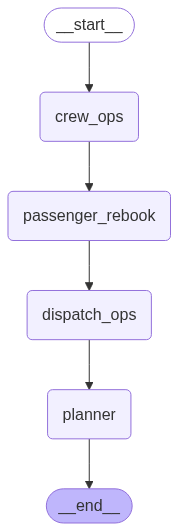

In [135]:
from IPython.display import Image, display

png = plan_executor.get_graph().draw_mermaid_png()
display(Image(png))

In [136]:
# === Updated Execution Code - Copy and paste this to replace your execution cell ===


# Initialize state with additional fields for enhanced functionality
initial_state = {
    "proposals": [],
    "crew_schedule": mock_crew_schedule,
    "passenger_itinerary": mock_passenger_itinerary,
    "flight_crew_mapping": {},      # For crew tracking
    "crew_substitutions": {},       # For substitution tracking
    "current_flight_crews": {},     # For current assignments
    "legality_flags": [],           # For compliance tracking
    "messages": [],                 # For message tracking
    "iteration_count": 0,           # For iteration tracking
    "weather_data": {},             # For dispatch ops
    "fuel_data": {}                 # For dispatch ops
}

print("🚀 Starting Multi-Agent Airline Operations Analysis...")
print("=" * 60)

# Execute the multi-agent system
output = plan_executor.invoke(initial_state)

print("=" * 60)
print("✅ Analysis Complete!")
print("=" * 60)


🚀 Starting Multi-Agent Airline Operations Analysis...
🧑‍✈️ Claude CrewOpsAgent activated


> Entering new AgentExecutor chain...

Invoking: `get_unassigned_crew_from_db` with `{}`
responded: [{'text': "I'll help you review the crew schedule for FAA compliance and resolve any violations. Let's follow the process step by step.\n\n1. First, let's get the unassigned crew from the database that we'll need for potential substitutions:", 'type': 'text', 'index': 0}, {'id': 'toolu_01U9msfgxhfV2SKTYRtSSdbc', 'input': {}, 'name': 'get_unassigned_crew_from_db', 'type': 'tool_use', 'index': 1, 'partial_json': ''}]

[{'crew_id': 'unassigned_0', 'name': 'Unassigned Crew 0', 'base': 'ORD', 'rest_hours_prior': 11.649058504500616, 'fatigue_score': 0.72, 'role': 'Attendant'}, {'crew_id': 'unassigned_1', 'name': 'Unassigned Crew 1', 'base': 'ORD', 'rest_hours_prior': 11.295326647088896, 'fatigue_score': 0.28, 'role': 'Attendant'}, {'crew_id': 'unassigned_2', 'name': 'Unassigned Crew 2', 'base': 'ORD', 'r